In [1]:
import sys,os 
sys.path.append('/home/benr/ACT/CW2/py')
import numpy as np 


import pandas as pd 
from PIL import Image, UnidentifiedImageError
from sklearn.preprocessing import LabelEncoder
from functions import get_data,split_data_torch,train_q2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

2025-12-09 10:28:39.185458: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 10:28:39.546292: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-09 10:28:40.845119: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
#Ensure CUDA is available. 
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))

CUDA available: True
CUDA version: 12.8
CUDA_VISIBLE_DEVICES: None


# Question 2, Convolutional Neural Network for image recognition 
In this section the aim is to repeat the same process as question 1 but replace the traditional reandom forest method with a convolutional neural network (**CNN**). The expectation is that due to the CNN's ability to correlate spacial features, it will be a more robust method of recognising galaxy morphology.

The first step will be to load the data in exactly the same way as Q1. 

In [3]:

# get the data from functions.py
images,labels = get_data()
# convert images to pytorch tnesors
images = torch.from_numpy(images)
labels = torch.from_numpy(labels).long()

print(images.shape)


/home/benr/.astroNN/datasets/Galaxy10_DECals.h5 was found!
torch.Size([17736, 256, 256, 3])


In [4]:
# Move channels: (N,H,W,C) -> (N,C,H,W)
images = images.permute(0, 3, 1, 2)      

# standardise 
images = images.float() / 255.0    
# The mean and standard deviation will be used later for normalisation   
mean = images.mean(dim=[0,2,3])
std = images.std(dim=[0,2,3])
print(images.shape)
print(mean)
print(std)

torch.Size([17736, 3, 256, 256])
tensor([0.1675, 0.1626, 0.1589])
tensor([0.1287, 0.1180, 0.1116])


# How do Convolutional Neural Networks work? 
Images are made up of pixels which have numerical values. The idea behind a convolutional neural network is to slide a 'kernel' (a grid of size (h $\cdot$ w)) across the image multiplying the values at each postion; this is called a **convolution**. The convolution of the image (I) and the kernel (K) is
$$
(I*K)_{i,j} = \sum_{k=1}^{h} \sum_{l=1}^{w} I_{i+k-1, j+l -1 } K_{kl} 
$$
Each layer of the CNN contains many of these kernels (also called filters). As the kernel slides over the image, the network measures how strongly different sections of the image match the patterns encoded on each kernel. The output of this process is known as a feature map. 

This idea is similar to the basic MLP with a few key exceptions, 


* Each node on the feature map corrosponds to a region on the image, so spacial properties are preserved. 

* In a MLP all nodes are connected, this is not the case for the CNN. Only nodes that are relavent to each other are connected. 

During training the values inside a kernal are initially set to small random vvalues, the network will update these values using **backpropogation**; this is how the network learns to detect specific image features. Between layers of the CNN there are often **pooling layers**, these are layers that are designed to reduce the size of the image whilst keeping the important information stored in the pixels. This is done by taking an area of the image (an $n$ x $n$ grid) and reducing it to one pixel by taking some average of these pixels.

After passing the image through multiple layers of a CNN it will then be passed to a fully connected MLP to predict the catagory of the image. 

Now we set up the class that will hold the structure of the network. Galaxy_CNN takes the number of input channels, the number of classes (Prediction catagories) and passes them two the different layers of the network. 

Throughout the process of data being passed through different levels of the CNN we will need to keep track of how each layer changes the size of each image. This can be done with the following formulas

* CNN Output - $$\frac{H + 2P -K}{s} + 1 $$
* Pooling Output - $$\frac{H-K}{s}  + 1$$

H = input height or width of image 

K = kernel size, (n x n) grid

P = padding size, zeros added onto the boarder of the image.

s = stride, how far the kernal moves after each convolution. 

In [5]:

class Galaxy_CNN(nn.Module):
    def __init__(self, inCH, nCL):  
        super(Galaxy_CNN, self).__init__()
        # conv blocks
        self.conv1 = nn.Conv2d(3, inCH, kernel_size=7, stride=1, padding=4)
        # batchnorm is a way of normalising the activation values
        self.bn1   = nn.BatchNorm2d(inCH)

        self.conv2 = nn.Conv2d(inCH, inCH*2, kernel_size=5, stride=2, padding=1)
        self.bn2   = nn.BatchNorm2d(inCH*2)

        self.conv3 = nn.Conv2d(inCH*2, inCH, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(inCH)

        self.pool = nn.MaxPool2d(2, 2)
        #dropout is a way of 'turning off' some nodes temporarily, to prevent overfitting
        self.dropout = nn.Dropout(0.4)
        # fully connected final layer 
        self.lin = nn.Linear(inCH*16**2, nCL)

    def forward(self, x):
        # The forward section passes the batch through the graph
        x = self.pool(F.relu(self.bn1(self.conv1(x))))# conv1 -> batchnorm -> relu -> pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x))))# conv2 -> batchnorm -> relu -> pooling 
        x = self.pool(F.relu(self.bn3(self.conv3(x))))# conv3 -> batchnorm -> relu -> pooling
        x = self.dropout(x) 
        #change shpae of tensor for linear layer (batch size,total features)    
        x = x.view(x.size(0), -1)    
        x = self.lin(x)
        return x

In [6]:
#split tensor into training and test sets (see functions.py)
I = np.arange(len(labels))
xtrn,xtst,ytrn,ytst = split_data_torch(images,labels,I)


# match images and labels in a torch dataset 
train_ds = TensorDataset(xtrn, ytrn)
test_ds  = TensorDataset(xtst, ytst)



#create train and test loaders for training
train_loader = DataLoader(
    train_ds, batch_size=5, shuffle=True,
    num_workers=4, pin_memory=True
)

test_loader  = DataLoader(
    test_ds, batch_size=5, shuffle=False,
    num_workers=4, pin_memory=True
)


In [7]:
# number of catagories 
num_classes = len(labels.unique())
# tell the computer to use the GPU via CUDA 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#The network model 
model = Galaxy_CNN(128,num_classes).to(device)

''' The criterion is the loss function, in this case we are using cross entropy. 
This function asigns probabilities to each catagory, for example [0,1,0,0...] might be
a spiral galaxy. Cross entropy then measures how close the outputs are to this true 
probability.'''
criterion = nn.CrossEntropyLoss()
# the method of gradient decent used in backpropogation. 
optimizer = torch.optim.Adam(model.parameters(),lr=10**-3,weight_decay=1e-4)

#for normalisation 
mean_tensor = mean.view(1,3,1,1).to(device)
std_tensor = std.view(1,3,1,1).to(device)


print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))


0
NVIDIA GeForce RTX 4060 Laptop GPU


Saved new best model (acc=0.4863)
Epoch 1/70 Train loss: 2.2390  Train acc: 0.342  Test acc: 0.486
Saved new best model (acc=0.5291)
Epoch 2/70 Train loss: 1.4398  Train acc: 0.478  Test acc: 0.529
Epoch 3/70 Train loss: 1.2965  Train acc: 0.537  Test acc: 0.509
Saved new best model (acc=0.5648)
Epoch 4/70 Train loss: 1.1505  Train acc: 0.596  Test acc: 0.565
Saved new best model (acc=0.6013)
Epoch 5/70 Train loss: 1.0334  Train acc: 0.634  Test acc: 0.601
Saved new best model (acc=0.6227)
Epoch 6/70 Train loss: 0.9128  Train acc: 0.680  Test acc: 0.623
Epoch 7/70 Train loss: 0.8128  Train acc: 0.714  Test acc: 0.621
Epoch 8/70 Train loss: 0.7294  Train acc: 0.746  Test acc: 0.622
Saved new best model (acc=0.6268)
Epoch 9/70 Train loss: 0.6523  Train acc: 0.775  Test acc: 0.627
Saved new best model (acc=0.6359)
Epoch 10/70 Train loss: 0.6023  Train acc: 0.791  Test acc: 0.636
Epoch 11/70 Train loss: 0.5368  Train acc: 0.814  Test acc: 0.632
Epoch 12/70 Train loss: 0.5063  Train acc: 0.

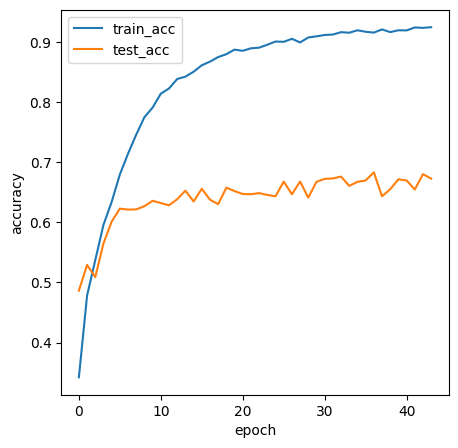

ValueError: x and y must have same first dimension, but have shapes (71,) and (44,)

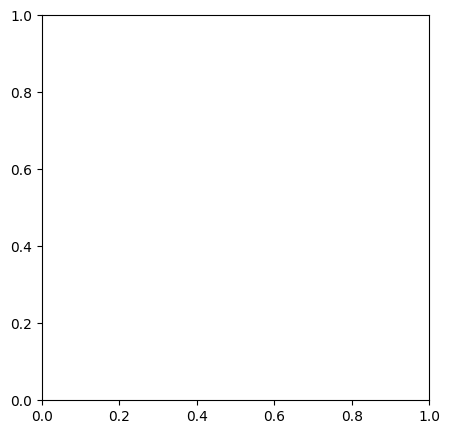

In [8]:
# calling the train_q2() function from functions.py 
train_q2(model, train_loader,test_loader,  
      mean_tensor,std_tensor,
      criterion, 
      optimizer, device, 
      n_epoch=70)


The training results show that there is an increase in accuracy compared to the random forest method. almost 70% of images have been placed in the correct catagory. This shows that the CNNs ability to recognise spacial features provides a significant improvement over the traditional method. 

However, looking at the training does show that there are some improvements to be made. After the third epoch the training accuracy significantly overtakes the test accuracy, this is a classic sign of **overfitting**. The network is simply 'memorising' the training images and the weights are being specifically taylored to the training set and not learning to recognise the different features of different types of galaxy. 

In Question three we will look at how we can use data augmentation to overcome this issue and increase the test accuracy further. 